# Notebook 5: One Class Network

## Pre-requisitos

### Instalar paquetes

Si la práctica requiere algún paquete de Python, habrá que incluir una celda en la que se instalen. Si usamos un paquete que se ha utilizado en prácticas anteriores, podríamos dar por supuesto que está instalado pero no cuesta nada satisfacer todas las dependencias en la propia práctica para reducir las dependencias entre ellas.

In [1]:
# Ejemplo de instalación de tensorflow 2.0
#%tensorflow_version 2.x
# !pip3 install tensorflow  # NECESARIO SOLO SI SE EJECUTA EN LOCAL
import tensorflow as tf

# Hacemos los imports que sean necesarios
import numpy as np

# One Class sobre datos artificiales

Lo primero que tenemos que hacer es definir los datos a utilizar.

In [2]:
random_state = 42
rng = np.random.RandomState(random_state)
#  datos de entrenamiento
X = 0.3 * rng.randn(5000, 2)
x_train = np.r_[X + 2, X - 2]
#  datos de test en la misma distribución que los datos de entrenamiento
X = 0.3 * rng.randn(200, 2)
x_testq= np.r_[X + 2, X - 2]
#  outliers
x_outliers = rng.uniform(low=-4, high=4, size=(200, 2))

In [3]:
print(x_train.shape, x_test.shape, x_outliers.shape)

(10000, 2) (400, 2) (200, 2)


## Crea tu propia red para la detección de anomalías

Vamos a crear nuestra propia red para la detección de anomalías. Para ello, vamos a definir una red cualquiera, que nos **transforme los datos de entrada en una salida de un único elemento**. Esta red va a cumplir una serie de características:

* La capa anterior a la salida serán las llamadas **deep features**.
* Todas las capas (incluyendo la última) deben incluir regularización.
* La función de coste es $$L(y, \tilde{y}) = \dfrac{1}{2} \| w^2 \| + \dfrac{1}{\nu} \dfrac{1}{N} \sum_{i=1}^N \max(0, r - \tilde{y}) $$ donde $\tilde{y}$ es la salida de la red, $\nu$ es un hiperparámetro entre 0 y 1, y $r$ es un parámetro no entrenable, pero que va a ser modificado en cada epoch.
* Al final del cada epoch, r va a ser modificado al valor del $\nu$-cuantil de los datos de entrada (este valor será modificado gracias al Callback proporcionado a continuación).
* Para la predicción, se considerará un dato típico si $\tilde{y} > r$. En caso contrario, será un dato atípico.

In [4]:
class ChangeRCallback(tf.keras.callbacks.Callback):
   def __init__(self, train_data, delta=.025, steps=3):
       super().__init__()
       self.train_data = train_data
       self.delta = delta
       self.steps = steps
       self.cont = 0

   def on_epoch_end(self, epoch, logs=None):
       sorted_values = np.sort(self.model.predict(self.train_data).flatten())
       new_value = sorted_values[int(len(sorted_values) * (1. - self.model.nu))]
       old_value = self.model.r.numpy()
       print('Cambiando r a', new_value, ', max:', sorted_values.max(), ', min:', sorted_values.min())
       self.model.r.assign(new_value)
       if np.abs(old_value - new_value) < self.delta:
            self.cont += 1
            if self.cont >= self.steps:
                print('Convergencia obtenida. Finalizando el entrenamiento.')
                self.model.stop_training = True
       else:
            self.cont = 0

Tu trabajo es crear el modelo y entrenarlo.

In [12]:
# TODO: implementa la red de detección de anomalías

class DetectorAnomalias:

	def __init__(self, input_shape, nu=.5):
		# TODO : define el modelo

		self.model = tf.keras.models.Sequential([
			tf.keras.layers.InputLayer(input_shape=input_shape),
			# Primera capa densa con regularización L2
			tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
            tf.keras.layers.Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
			# Segunda capa densa (deep features) con regularización L2
			tf.keras.layers.Dense(16, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01), name='deep_features'),
			# Capa de salida con regularización L2 (un único valor escalar)
			tf.keras.layers.Dense(1, kernel_regularizer=tf.keras.regularizers.l2(0.01))
		])

		self.model.r = tf.Variable(1.0, trainable=False, name='r', dtype=tf.float32)
		self.model.nu = tf.Variable(nu, trainable=False, name='nu', dtype=tf.float32)
		
	  
	def loss_function(self, y_true, y_pred):
		# TODO: crea la función de pérdida
		# w = self.model.layers[-1].kernel
		r = self.model.r
		nu = self.model.nu
		
		# Primera parte: regularización L2 (ya incluida por los regularizadores de capa)
		# Segunda parte: término de error basado en el margen r
		# max(0, r - y_pred) para cada predicción
		margin_error = tf.maximum(0.0, r - y_pred)
		# Calculamos la media y aplicamos el factor 1/nu
		margin_loss = tf.reduce_mean(margin_error) / nu
		
		# La función de pérdida total (la regularización ya está incluida en las capas)
		return margin_loss
	
	def fit(self, X, y=None, sample_weight=None):
		# TODO: entrena el modelo. Escoge el tamaño de batch y el número de epochs que quieras. No te olvides del callback.
		dummy_y = np.zeros((len(X), 1)) # Necesario pasar como salida para que keras no de un error

		self.model.compile(optimizer='adam', loss=self.loss_function)
		self.model.fit(X, dummy_y, callbacks=[ChangeRCallback(X)], batch_size=64, epochs=50, verbose=1)
		return self.model
		
	def predict(self, X):
		# TODO: Devuelve la predicción del modelo
		return self.model.predict(X)

	def get_encoded_data(self, X):
		# TODO: devuelve la salida del encoder (code)
		return self.model.layers[1].predict(X)
		
	def __del__(self):
		# TODO: borra el modelo
		del self.model
		tf.keras.backend.clear_session() # Necesario para liberar la memoria en GPU

### Entrena el modelo.

Usa lo hecho anteriormente para entrenar tu modelo.

In [15]:
# TODO: Define el modelo
def model_func():
    model = DetectorAnomalias(input_shape=(2,))
    return model

In [16]:
# TODO: Entrena tu modelo
model = model_func()
model.fit(x_train)

Epoch 1/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.6942
Cambiando r a 1.0942782 , max: 1.105661 , min: 1.065046
157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 1.6908
Epoch 2/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.7264 
Cambiando r a 1.2487328 , max: 1.2840917 , min: 1.1790736
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.7249
Epoch 3/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.7459 
Cambiando r a 1.7553259 , max: 1.8424593 , min: 1.6351668
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.7446
Epoch 4/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.7803 
Cambiando r a 2.0930285 , max: 2.1964984 , min: 1.9354051
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.7798
Epoch 5/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.0211 
Cambiando r a 3.746944 , max: 4.1440578 , min: 2.7282252
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 1.0233
Epoch 6/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.1741
Cambiando r a 6.168547

<Sequential name=sequential_3, built=True>

## Evaluando el modelo

Una vez entrenado, para evaluar el modelo sólo hay que tener en cuenta lo siguiente:

  1. Si la salida es mayor que r, es un dato típico.
  1. Si la salida es menor que r, es un dato atípico.

### TRABAJO: Evalúa el modelo con los datos del conjunto de test, y con los outliers. Visualiza los datos típicos y atípicos con una gráfica.

In [17]:
# TODO: Evalúa el modelo con los datos del conjunto de test. Indica el porcentaje de datos etiquetados como típicos, y visualiza los datos
predicciones = model.predict(x_test)

# Determinamos qué datos son típicos (normales) y cuáles son anomalías
# Un dato es típico si su predicción es mayor que r
r_valor = model.model.r.numpy()
es_tipico = predicciones > r_valor

# Calculamos el porcentaje de datos etiquetados como típicos
porcentaje_tipicos = np.mean(es_tipico) * 100

print(f"Valor de r: {r_valor:.4f}")
print(f"Porcentaje de datos etiquetados como típicos: {porcentaje_tipicos:.2f}%")
print(f"Porcentaje de datos etiquetados como anomalías: {100 - porcentaje_tipicos:.2f}%")

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Valor de r: 12500.6348
Porcentaje de datos etiquetados como típicos: 50.00%
Porcentaje de datos etiquetados como anomalías: 50.00%


In [18]:
# TODO: Evalúa el modelo con los datos del conjunto de outliers. Indica el porcentaje de datos etiquetados como atípicos, y visualiza los datos en conjunto con los de test
predicciones_outliers = model.predict(x_outliers)
r_valor = model.model.r.numpy()
es_atipico_outliers = predicciones_outliers <= r_valor
porcentaje_atipicos_outliers = np.mean(es_atipico_outliers) * 100

# Evaluamos también los datos de test para comparar
predicciones_test = model.predict(x_test)
es_atipico_test = predicciones_test <= r_valor

print(f"Porcentaje de outliers etiquetados como atípicos: {porcentaje_atipicos_outliers:.2f}%")

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Porcentaje de outliers etiquetados como atípicos: 75.00%


¿Qué resultados has obtenido? Si el número de outliers detectado es bajo (inferior al 30%), puedes estar cometiendo algún error, entre ellos:

* Sobreentrenar el modelo. Prueba a usar un delta distinto en el callback.
* Usar un valor de $\nu$ demasiado alto.

Prueba distintas configuraciones para ver su efecto.

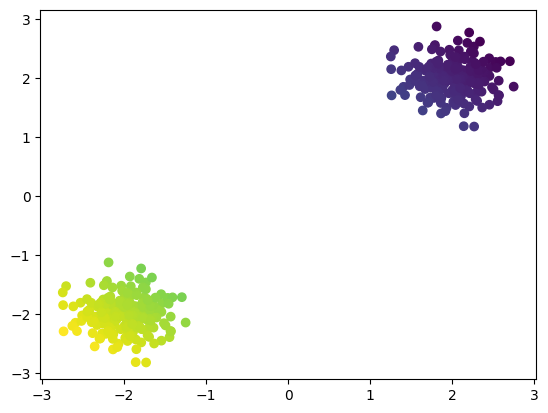

In [32]:
plt.scatter(x_test[:,0],x_test[:,1],c=predicciones)